# Prime numbers
This demonstration is about prime numbers and its similarity based on its factors. This is a well-known demonstration of `SimSearchManifoldLearning.jl`. This notebook does not requires to download any dataset.

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

_june 2nd, 2023: working with `SimilaritySearch` v0.10. I also moved from `Plots` to `Makie`._

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/SimilaritySearchDemos/primes`


In [2]:
using Pkg
Pkg.activate(".")
if !isfile("Manifest.toml")
    Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.10"),
        PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
        PackageSpec(name="CairoMakie"),
        PackageSpec(name="ColorSchemes"),
        PackageSpec(name="Colors"),
        PackageSpec(name="Primes"),
        PackageSpec(name="StatsBase"),
        PackageSpec(name="HypertextLiteral"),
    ])
end

using SimilaritySearch, SimSearchManifoldLearning, CairoMakie, ColorSchemes, Colors
using Primes, StatsBase, LinearAlgebra, HypertextLiteral

  Activating project at `~/Research/SimilaritySearchDemos/primes`


Now, we can define our dataset. The set of factors are found using the `Primes` package. Note that we use `VectorDatabase` to represent the dataset.

In [3]:
n = 100_000
F = Vector{Vector{Int32}}(undef, n)

for i in 2:n+1
    s = Int32[convert(Int32, f) for f in factor(Set, i)]
    sort!(s)
    F[i-1] = s
end

db = VectorDatabase(F)

VectorDatabase{Vector{Vector{Int32}}}(Vector{Int32}[[2], [3], [2], [5], [2, 3], [7], [2], [3], [2, 5], [11]  …  [2, 29, 431], [3, 33331], [2, 17, 173], [5, 7, 2857], [2, 3, 13, 641], [19, 277], [2, 49999], [3, 41, 271], [2, 5], [11, 9091]])

We use Int32 ordered arrays to store prime factors to represent each integer. In the following cell define the cosine distance equivalent for this representation. While other representations may perform faster, this is quite straighforward and demonstrates the use of user's defined distance functions.

## Index construction
Note that the primes factors are pretty large for some large $n$ and this imply challengues for metric indexes (since it is related with the intrinsic dimension of the dataset). We used a kernel that starts 64 threads, it solves $100000$ in a few seconds but it can take pretty large time using single threads and larger $n$ values. The construction of the index is used by the visualization algorithm (UMAP) to construct an all-knn graph, which can be a quite costly procedure.

In [4]:
#dist = JaccardDistance()  # Other distances from SimilaritySearch
dist = DiceDistance()
#dist = IntersectionDissimilarity()
#dist = CosineDistanceSet()
G = SearchGraph(; db, dist)
index!(G; parallel_block=1000)
IJulia.clear_output()

0

In [5]:
function umap_embeddings(index, db; k=20, n_epochs=100, neg_sample_rate=5, tol=1e-3, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol) 
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    #jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    if length(index) == length(db)
        e2 = predict(U2)
        e3 = predict(U3)
    else
        @time e2 = clamp.(predict(U2, db), -10f0, 10f0)
        @time e3 = clamp.(predict(U3, db), -10f0, 10f0)
    end
    (; e2, e3)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end


normcolors (generic function with 1 method)

## Visualizing with UMAP projection
We select to initialize the embedding randomly, this could yield to low quality embeddings, but it is much faster than other techniques like spectral layout. Note that we pass the Search graph `G`. We also use a second call to compute a 3D embedding for computing a kind of colour embedding, here we pass `U2` to avoid recomputing several of the involved structures.

In [6]:
e2, e3 = umap_embeddings(G, database(G))

  2.437924 seconds (100.06 k allocations: 16.786 MiB, 3.68% gc time)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


 68.331630 seconds (2.40 M allocations: 149.680 GiB, 0.35% gc time, 3.46% compilation time)


UMAP construction time cost report:
- fuzzy graph: 0.503671542
- embedding init: 51.376676045
- embedding opt: 13.607636591



 14.169811 seconds (1.52 k allocations: 2.732 MiB)


(e2 = Float32[-2.273882 -4.9071126 … -4.0464525 2.8395133; 7.0173335 -2.8012033 … 4.8186145 5.8820643], e3 = Float32[-0.26753116 -4.3564267 … -2.0415177 3.1900237; 9.185151 -2.4971292 … 7.0205083 6.550568; 0.5643253 1.0404654 … -1.0473791 -0.53277606])

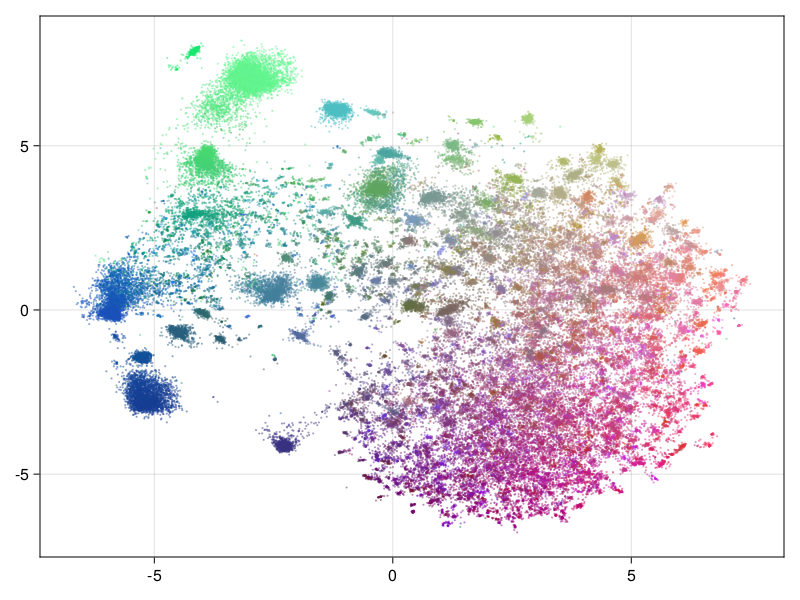

In [7]:
function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGBAf(c[1], c[2], c[3], 0.5) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    scatter(X, Y, color=C, markersize=3)
end


plot_umap(e2, e3)

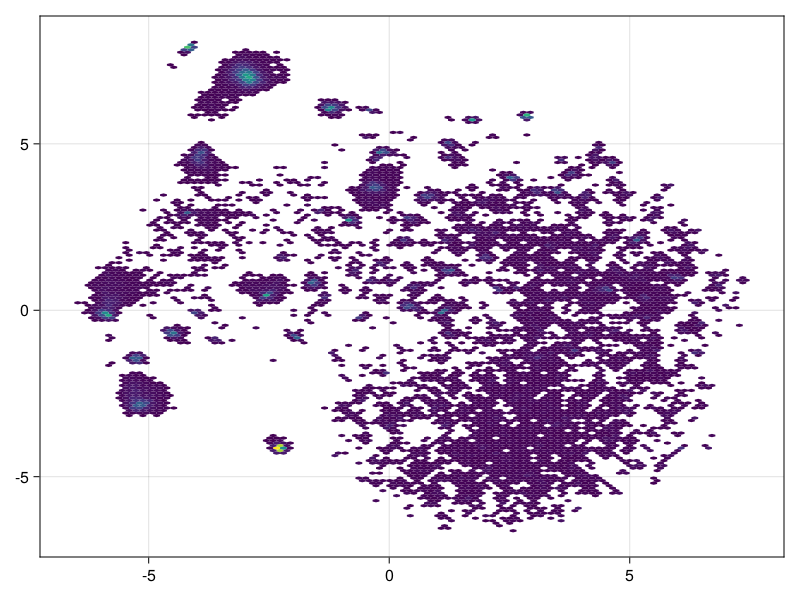

In [8]:
hexbin(e2[1, :], e2[2, :]; bins=200, threshold=5)